In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set style for the plots
plt.style.use('seaborn-v0_8')

In [130]:
df_lvl = pd.read_csv("../data/processed/water_levels_daily.csv", parse_dates=["timestamp"])
daily_levels = (
    df_lvl.set_index("timestamp")["value"]
           .resample("D").mean()
           .interpolate()                       # close tiny gaps if any
)

daily_df = daily_levels.to_frame(name="water_level")

doy     = daily_df.index.dayofyear
ang_yr  = 2 * np.pi * doy / 365.25
dow     = daily_df.index.dayofweek
ang_wk  = 2 * np.pi * dow / 7

daily_df["sin365"] = np.sin(ang_yr)
daily_df["cos365"] = np.cos(ang_yr)
# daily_df["sin7"]   = np.sin(ang_wk)
# daily_df["cos7"]   = np.cos(ang_wk)

In [131]:
weather_raw = (
    pd.read_csv(
        "../data/raw/edersee_historical_weather.csv",
        skiprows=3,                       # first 2 meta lines + blank line
        parse_dates=["time"],
    )
    .rename(columns={"time": "timestamp"})
)

weather = (
    weather_raw
      .set_index("timestamp")
      .sort_index()
      .resample("D").mean()
      .interpolate(limit=7)               # close small gaps
)

# Drop weather_code column
weather.drop(columns=["weather_code (wmo code)"], inplace=True)

In [132]:
anchor_template = [
    ("11-01", 237.30),  # 1 Nov
    ("12-15", 237.30),
    ("01-01", 239.61),
    ("02-01", 241.71),
    ("03-01", 242.70),
    ("04-01", 244.10),
    ("05-01", 244.95),  # 1 May
]

def compute_max_level_series(dates: pd.DatetimeIndex) -> pd.Series:
    def cap_on(day: pd.Timestamp) -> float:
        year0 = day.year if day.month >= 11 else day.year - 1
        pts   = []
        for mm_dd, lvl in anchor_template:
            mm, dd = map(int, mm_dd.split("-"))
            yr     = year0 if mm >= 11 else year0 + 1
            try:
                pts.append((pd.Timestamp(yr, mm, dd), lvl))
            except ValueError:  # 29 Feb on non-leap
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])
        if day < pts[0][0] or day >= pts[-1][0]:
            return pts[-1][1]
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= day <= d1:
                frac = (day - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1]

    return pd.Series([cap_on(d) for d in dates], index=dates, name="max_level_m")

max_level = compute_max_level_series(daily_df.index)

daily_df["max_level_m"] = max_level

In [133]:
df = pd.merge(
    daily_df,
    weather,
    left_index=True,
    right_index=True,
    how="left",
)

df.to_csv("../data/processed/water_levels_weather.csv", index=True)

In [186]:
# ---------- Load data ----------
file_path = '../data/processed/water_levels_weather.csv'
df = pd.read_csv(file_path, parse_dates=['timestamp'])

# ---------- Feature engineering ----------
# Target: water level 28 days ahead
HORIZON = 28  # days
df['target'] = df['water_level'].shift(-HORIZON)

df["pred_date"] = df["timestamp"] + pd.Timedelta(days=HORIZON)

# Lag features of water level
lag_days = [1, 2, 3, 7, 14, 21, 365]  # 1 year = 365 days, 2 years = 730 days
for l in lag_days:
    df[f'lag_{l}'] = df['water_level'].shift(l)

# Rolling statistics of water level (exclude current day to prevent leakage)
roll_windows = [7, 14, 28]
for w in roll_windows:
    df[f'rolling_mean_{w}'] = df['water_level'].shift(1).rolling(window=w).mean()
    df[f'rolling_std_{w}'] = df['water_level'].shift(1).rolling(window=w).std()

# Day-of-year to capture intra‑annual seasonality (already have sin/cos, but add raw DOY as well)
df['day_of_year'] = df['timestamp'].dt.dayofyear

# Drop any rows with NaNs introduced by shifting/rolling
df = df.dropna().reset_index(drop=True)

df

,timestamp,water_level,sin365,cos365,max_level_m,snowfall_sum (cm),precipitation_sum (mm),precipitation_hours (h),cloud_cover_mean (%),et0_fao_evapotranspiration (mm),...,lag_14,lag_21,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,day_of_year
0,2000-12-31,237.09,0.012901,0.999917,239.474118,0.0,0.0,0.0,72.0,0.32,...,236.03,233.92,239.62,237.205714,0.041975,236.980000,0.385247,235.557500,1.553895,366
1,2001-01-01,237.03,0.017202,0.999852,239.610000,0.0,4.9,13.0,95.0,0.42,...,236.33,234.03,239.42,237.185714,0.058554,237.055714,0.271569,235.688571,1.521361,1
2,2001-01-02,236.98,0.034398,0.999408,239.677742,0.0,1.5,5.0,63.0,0.27,...,236.63,234.20,239.18,237.155714,0.076997,237.105714,0.174916,235.816786,1.475423,2
3,2001-01-03,236.98,0.051584,0.998669,239.745484,0.0,0.5,3.0,65.0,0.25,...,236.85,234.49,239.09,237.118571,0.091000,237.130714,0.117176,235.939286,1.421660,3
4,2001-01-04,237.14,0.068755,0.997634,239.813226,0.0,1.5,9.0,99.0,0.31,...,237.05,234.88,239.08,237.082857,0.089016,237.140000,0.096556,236.058929,1.359734,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8848,2025-03-23,242.51,0.987196,0.159513,243.693548,0.0,3.4,11.0,91.0,1.69,...,242.41,242.17,242.98,242.488571,0.008997,242.472857,0.027576,242.296071,0.225476,82
8849,2025-03-24,242.51,0.989794,0.142508,243.738710,0.0,4.6,12.0,62.0,1.73,...,242.42,242.22,243.05,242.491429,0.012150,242.480000,0.022532,242.321786,0.205824,83
8850,2025-03-25,242.52,0.992099,0.125461,243.783871,0.0,0.0,0.0,59.0,2.12,...,242.45,242.25,243.12,242.492857,0.013801,242.486429,0.015984,242.346429,0.183630,84
8851,2025-03-26,242.51,0.994110,0.108377,243.829032,0.0,0.8,6.0,73.0,1.33,...,242.47,242.28,243.25,242.497143,0.017043,242.491429,0.014601,242.368571,0.164152,85


In [194]:
# ---------- Train / validation split ----------
train_end = pd.Timestamp("2017-12-31")
val_end   = pd.Timestamp("2020-12-31")

# Split by pred_date, not timestamp
train_df = df[df["pred_date"] <= train_end]
val_df   = df[(df["pred_date"] > train_end) & (df["pred_date"] <= val_end)]
test_df  = df[df["pred_date"] > val_end]           # keep for later

# Keep only rows that still have a target
train_df = train_df.dropna(subset=["target"])
val_df   = val_df.dropna(subset=["target"])

# Build features/labels
exceptions = ["timestamp", "pred_date", "target",
              'precipitation_sum (mm)', 'snowfall_sum (cm)']
feature_cols = [c for c in train_df.columns if c not in
                exceptions]

X_train, y_train = train_df[feature_cols], train_df["target"]
X_val,   y_val   = val_df[feature_cols],   val_df["target"]

In [195]:
model = xgb.XGBRegressor(
    objective='reg:squarederror', # Objective function for regression
    n_estimators=1000,            # Number of boosting rounds (trees)
    learning_rate=0.01,           # Step size shrinkage
    max_depth=7,                  # Maximum depth of a tree
    subsample=0.7,                # Fraction of samples used per tree
    colsample_bytree=0.7,         # Fraction of features used per tree
    random_state=26,              # Seed for reproducibility
    n_jobs=-1,                    # Use all available CPU cores
    early_stopping_rounds=50      # Stop training if validation score doesn't improve
)

# Use the last part of the training set as a validation set for early stopping
eval_set = [(X_val, y_val)] # Evaluate directly on the test set for early stopping in this case
                              # More robust: create a validation set from the end of the training set

model.fit(X_train, y_train,
              eval_set=eval_set,
              verbose=100) # Print evaluation metric every 100 rounds

[0]	validation_0-rmse:10.68557


[100]	validation_0-rmse:4.72159
[200]	validation_0-rmse:2.64953
[300]	validation_0-rmse:2.01570
[400]	validation_0-rmse:1.85617
[500]	validation_0-rmse:1.80303
[600]	validation_0-rmse:1.78755
[700]	validation_0-rmse:1.78429
[800]	validation_0-rmse:1.78462
[801]	validation_0-rmse:1.78467


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

--------------------------------------------------
Validation MAE  : 1.4113 m
Validation RMSE : 1.7825 m
--------------------------------------------------


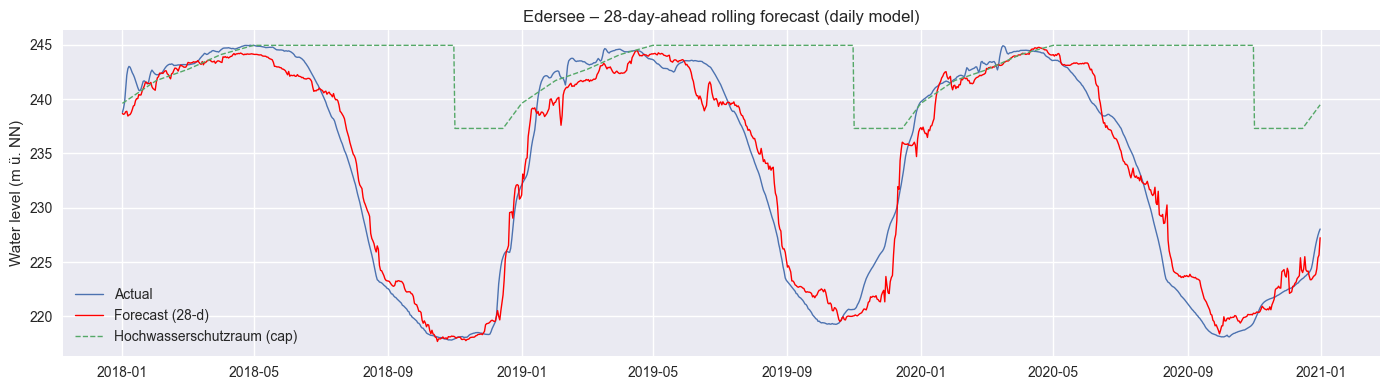

In [196]:
# --------------------------------------------------
# 8. Validation metrics
# --------------------------------------------------
val_pred = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, val_pred))
mae  = mean_absolute_error(y_val, val_pred)

print("-" * 50)
print(f"Validation MAE  : {mae:6.4f} m")
print(f"Validation RMSE : {rmse:6.4f} m")
print("-" * 50)

# (optional) Feature importance:
# importances = model.get_booster().get_score(importance_type="gain")

# --------------------------------------------------
# 9. Quick plot
# --------------------------------------------------
plot_dates = val_df["pred_date"]                  # already T+28
dyn_cap    = compute_max_level_series(plot_dates).values

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(plot_dates, y_val,     label="Actual",          lw=1)
ax.plot(plot_dates, val_pred,  label="Forecast (28-d)", lw=1, color="red")
ax.plot(plot_dates, dyn_cap,   label="Hochwasserschutzraum (cap)",
                               ls="--", lw=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee – 28-day-ahead rolling forecast (daily model)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

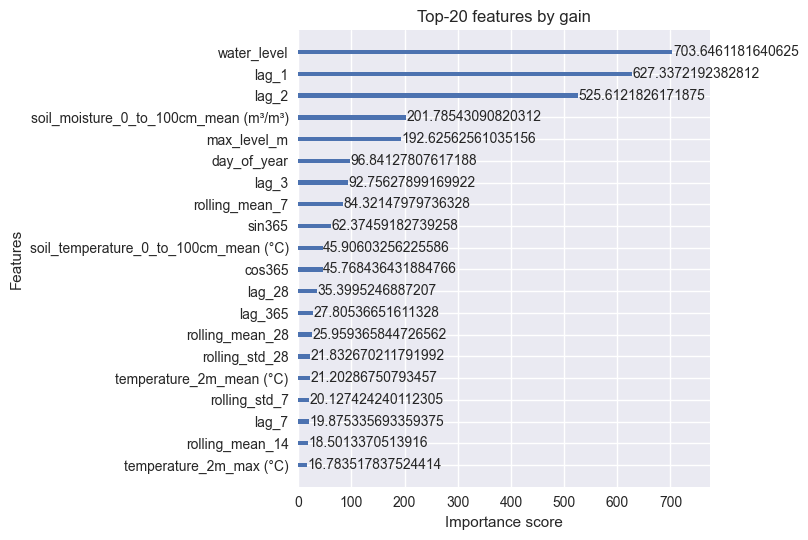

In [89]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# make sure `model` is already fitted
plot_importance(
    model,                       # the fitted XGBRegressor
    max_num_features=20,         # top‑20
    importance_type="gain"       # average loss‑reduction brought by splits
)
plt.title("Top-20 features by gain")
plt.tight_layout()
plt.show()

In [159]:
import pandas as pd

booster = model.get_booster()                     # same fitted model
gain    = booster.get_score(importance_type="gain")
weight  = booster.get_score(importance_type="weight")

imp_df = (pd.Series(gain, name="gain")
            .to_frame()
            .assign(weight=lambda d: d.index.map(weight).fillna(0).astype(int))
            .sort_values("gain", ascending=False))

imp_df

,gain,weight
lag_1,760.448303,1601
water_level,748.825317,8153
lag_2,533.462158,1095
max_level_m,256.785919,736
soil_moisture_0_to_100cm_mean (m³/m³),207.065674,5666
lag_3,174.458618,989
day_of_year,108.346069,1491
rolling_mean_7,105.646484,815
sin365,78.317406,7486
cos365,54.102306,4418


In [ ]:
imp_df.index

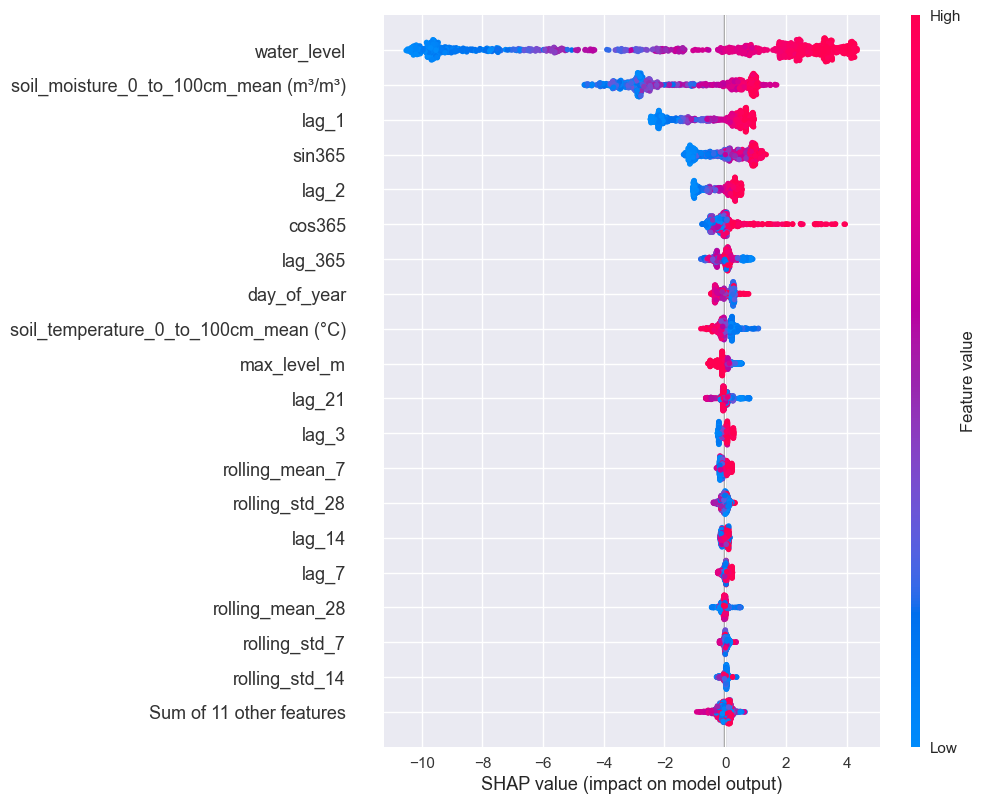

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [197]:
import shap
explainer = shap.Explainer(model)        # TreeExplainer under the hood
shap_vals = explainer(X_val)             # SHAP for validation set

# summary beeswarm
shap.plots.beeswarm(shap_vals, max_display=20)

# dependence plot for a single variable
shap.plots.scatter(
    shap_vals[:, "wl_lag_28"],           # SHAP value for that feature
    color=shap_vals                      # color by interaction
)